## Forecasting of cryptocurrency prices using a convolutional neural network

In this notebook, we use a simplified version of the convolutional neural network architecture [WaveNet](https://deepmind.com/blog/article/wavenet-generative-model-raw-audio) to perform next-day forecasts of the closing prices of 6 cryptocurrencies.

### 1. Closing price data
First, we define two small functions to download closing prices data from [Yahoo Finance](https://finance.yahoo.com/):

In [37]:
from datetime import datetime, date, time, timezone
import pandas as pd
import requests

def yahoo_url(ticker: str, from_day: str, to_day: str) -> str:
    """Return url to request yahoo finance."""
    from_dt = int(
        datetime.combine(
            date.fromisoformat(from_day), time(), tzinfo=timezone.utc)
            .timestamp()
    )
    to_dt = int(
        datetime.combine(
            date.fromisoformat(to_day), time(), tzinfo=timezone.utc)
            .timestamp()
    )
    return (
        "https://query1.finance.yahoo.com/v7/finance/download/"
        f"{ticker.upper()}"
        f"?period1={from_dt}&period2={to_dt}&interval=1d"
        "&events=history&includeAdjustedClose=true"
    )

In [10]:
def yahoo_to_series(ticker: str, from_day: str, to_day: str) -> pd.Series:
    """Return closing prices for ticker from Yahoo finance."""
    def to_float(str):
        if str == 'null':
            return None
        else:
            return float(str)
    url = yahoo_url(ticker, from_day, to_day)
    r = requests.get(url)
    content = r.content.decode('utf-8')
    try:
        d = {s.split(',')[0]: to_float(s.split(',')[4])
            for s in content.split('\n')[1:]}
        print(f'Downloaded closing prices for {ticker}')
    except IndexError:
        print(f'Request returned {r}\ncould not parse {ticker}')
        return None
    ser = pd.Series(data=d,
                    name=ticker.upper(),
                    dtype='float32')
    ser.index = pd.to_datetime(ser.index)
    ser.index.name = 'date'
    return ser

We then use these functions to download 1 year of closing prices in USD for Ethereum, Bitcoin, Stellar Lumens, Ripple, Cardano, and Chainlink, from March 1, 2021 to May 1, 2020. We save them as Pandas series.

In [11]:
tickers = ['ETH-USD', 'BTC-USD', 'XLM-USD',
           'XRP-USD', 'ADA-USD', 'LINK-USD']
from_day = '2020-05-01'
to_day = '2021-05-01'

series = [yahoo_to_series(ticker, from_day, to_day) for ticker in tickers]

Request returned <Response [401]>
could not parse ETH-USD
Request returned <Response [401]>
could not parse BTC-USD
Request returned <Response [401]>
could not parse XLM-USD
Request returned <Response [401]>
could not parse XRP-USD
Request returned <Response [401]>
could not parse ADA-USD
Request returned <Response [401]>
could not parse LINK-USD


Finally, we concatenate the series to form a dataframe with the closing prices for the 6 crytpocurrencies.

In [45]:
prices = pd.concat(series, axis=1, join='outer')
prices.dropna(axis=0, how='all', inplace=True)
prices.head()

,ETH-USD,BTC-USD,XLM-USD,XRP-USD,ADA-USD,LINK-USD
date,,,,,,
2020-05-01,214.219101,8864.766602,0.073222,0.219248,0.051260,3.783184
2020-05-02,215.325378,8988.596680,0.075450,0.223914,0.051014,3.822183
2020-05-03,210.933151,8897.468750,0.073106,0.219414,0.048929,3.722169
2020-05-04,208.174011,8912.654297,0.073738,0.218963,0.049664,3.767900
2020-05-05,206.774399,9003.070312,0.072445,0.216463,0.049358,3.687693


<br>

### 2. Training and test sets
The input data to the convolutional network are simply the closing prices for the whole time series except the last point.<br>
Our goal is, given a series of daily closing prices of arbitrary length, to predict the closing price on the following day. Therefore, the labels are given by the original time series shifted by 1 day.<br><br>

We further split the 1 year of closing price data and assign the first 292 days (80%) to the training set, and the next 73 days (20%) to the test set. The test set will not be used during training of the convolutional network (i.e., the neural network model does not know a priori anything on time series patterns in the test set), but only to validate the model after training.

In [46]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

X = prices.iloc[:-1, ].values.astype(np.float64)
y = prices.iloc[1:, :].values.astype(np.float64)

n_train = int(len(prices) * 0.8)
X_train, y_train = X[:n_train, :], y[:n_train, :]
X_test, y_test = X[n_train:, :], y[n_train:, :]

sc = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = sc.fit_transform(X_train)
y_train_scaled = sc.fit_transform(y_train)
X_test_scaled = sc.fit_transform(X_test)
y_test_scaled = sc.fit_transform(y_test)

X_train_scaled = X_train_scaled.reshape((1,) + X_train_scaled.shape)
y_train_scaled = y_train_scaled.reshape((1,) + y_train_scaled.shape)
X_test_scaled = X_test_scaled.reshape((1,) + X_test_scaled.shape)
y_test_scaled = y_test_scaled.reshape((1,) + y_test_scaled.shape)

print(X_train_scaled.shape)

(1, 290, 6)


<br>

### 3. Convolutional neural network (the model)

The convolutional neural network is defined using Keras. The architecture is a simplified version of [WaveNet](https://deepmind.com/blog/article/wavenet-generative-model-raw-audio), which uses successive 1D convolutional layers with dilation rates of 1, 2, 4, and 8, which allows to efficiently infer patterns from short- to long-term scales.

In [47]:
inputs = keras.layers.Input(shape=(None, len(tickers)))
conv_1 = keras.layers.Conv1D(
    20, kernel_size=2, padding='causal',
    activation='relu', name='conv_1',
)(inputs)
conv_2 = keras.layers.Conv1D(
    20, kernel_size=2, padding='causal',
    activation='relu', dilation_rate=2, name='conv_2'
)(conv_1)
conv_3 = keras.layers.Conv1D(
    20, kernel_size=2, padding='causal',
    activation='relu', dilation_rate=4, name='conv_3'
)(conv_2)
conv_4 = keras.layers.Conv1D(
    20, kernel_size=2, padding='causal',
    activation='relu', dilation_rate=8, name='conv_4'
)(conv_3)
outputs = keras.layers.Conv1D(
    len(tickers), kernel_size=1,
    name='output'
)(conv_4)

model = keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, 6)]         0         
_________________________________________________________________
conv_1 (Conv1D)              (None, None, 20)          260       
_________________________________________________________________
conv_2 (Conv1D)              (None, None, 20)          820       
_________________________________________________________________
conv_3 (Conv1D)              (None, None, 20)          820       
_________________________________________________________________
conv_4 (Conv1D)              (None, None, 20)          820       
_________________________________________________________________
output (Conv1D)              (None, None, 6)           126       
Total params: 2,846
Trainable params: 2,846
Non-trainable params: 0
_________________________________________________________

<br>

### 4. Training

It is now time to train the network. We use the Adam optimizer, and the mean absolute error as a loss function (i.e., L1 norm), which is less sensitive to outliers than the mean squared error (i.e., L2 norm). We run the model for 200 epochs.

In [48]:
optimizer = keras.optimizers.Adam()

loss = keras.losses.MeanAbsoluteError()

model.compile(optimizer=optimizer, loss=loss)

model.fit(X_train_scaled, y_train_scaled, epochs=200, batch_size=1,
          validation_data=(X_test_scaled, y_test_scaled))

Epoch 1/200
1/1 [==============================] - 1s 570ms/step - loss: 0.1569 - val_loss: 0.3113
Epoch 2/200
1/1 [==============================] - 0s 32ms/step - loss: 0.1487 - val_loss: 0.2994
Epoch 3/200
1/1 [==============================] - 0s 30ms/step - loss: 0.1413 - val_loss: 0.2894
Epoch 4/200
1/1 [==============================] - 0s 31ms/step - loss: 0.1346 - val_loss: 0.2812
Epoch 5/200
1/1 [==============================] - 0s 29ms/step - loss: 0.1285 - val_loss: 0.2744
Epoch 6/200
1/1 [==============================] - 0s 32ms/step - loss: 0.1230 - val_loss: 0.2689
Epoch 7/200
1/1 [==============================] - 0s 30ms/step - loss: 0.1182 - val_loss: 0.2648
Epoch 8/200
1/1 [==============================] - 0s 32ms/step - loss: 0.1139 - val_loss: 0.2617
Epoch 9/200
1/1 [==============================] - 0s 31ms/step - loss: 0.1097 - val_loss: 0.2599
Epoch 10/200
1/1 [==============================] - 0s 32ms/step - loss: 0.1055 - val_loss: 0.2591
Epoch 11/200
1/1 [

Epoch 84/200
1/1 [==============================] - 0s 33ms/step - loss: 0.0418 - val_loss: 0.1980
Epoch 85/200
1/1 [==============================] - 0s 35ms/step - loss: 0.0416 - val_loss: 0.1973
Epoch 86/200
1/1 [==============================] - 0s 30ms/step - loss: 0.0413 - val_loss: 0.1973
Epoch 87/200
1/1 [==============================] - 0s 28ms/step - loss: 0.0411 - val_loss: 0.1974
Epoch 88/200
1/1 [==============================] - 0s 30ms/step - loss: 0.0409 - val_loss: 0.1976
Epoch 89/200
1/1 [==============================] - 0s 29ms/step - loss: 0.0407 - val_loss: 0.1974
Epoch 90/200
1/1 [==============================] - 0s 28ms/step - loss: 0.0404 - val_loss: 0.1970
Epoch 91/200
1/1 [==============================] - 0s 29ms/step - loss: 0.0402 - val_loss: 0.1965
Epoch 92/200
1/1 [==============================] - 0s 31ms/step - loss: 0.0400 - val_loss: 0.1965
Epoch 93/200
1/1 [==============================] - 0s 31ms/step - loss: 0.0398 - val_loss: 0.1968
Epoch 94/2

1/1 [==============================] - 0s 29ms/step - loss: 0.0279 - val_loss: 0.1793
Epoch 167/200
1/1 [==============================] - 0s 30ms/step - loss: 0.0278 - val_loss: 0.1798
Epoch 168/200
1/1 [==============================] - 0s 29ms/step - loss: 0.0276 - val_loss: 0.1798
Epoch 169/200
1/1 [==============================] - 0s 30ms/step - loss: 0.0275 - val_loss: 0.1793
Epoch 170/200
1/1 [==============================] - 0s 31ms/step - loss: 0.0273 - val_loss: 0.1794
Epoch 171/200
1/1 [==============================] - 0s 30ms/step - loss: 0.0272 - val_loss: 0.1797
Epoch 172/200
1/1 [==============================] - 0s 29ms/step - loss: 0.0271 - val_loss: 0.1791
Epoch 173/200
1/1 [==============================] - 0s 30ms/step - loss: 0.0270 - val_loss: 0.1793
Epoch 174/200
1/1 [==============================] - 0s 30ms/step - loss: 0.0268 - val_loss: 0.1800
Epoch 175/200
1/1 [==============================] - 0s 30ms/step - loss: 0.0267 - val_loss: 0.1791
Epoch 176/200


<br>

### 5. Model check on training data, and validation on test data

Below we define a small function to plot the actual and predicted closing prices.

In [8]:
import matplotlib.pyplot as plt

def plot(y_true, y_pred, title=None):
    n_col = np.sqrt(y_true.shape[-1]).astype('int')
    n_row = np.ceil(y_true.shape[-1] / n_col).astype('int')
    fig, axes = plt.subplots(n_row, n_col, figsize=(10, 8))
    for i, ax in enumerate(axes.ravel()):
        ax.plot(y_true[0, :, i], label=f'{tickers[i]} true')
        ax.plot(y_pred[0, :, i], label=f'{tickers[i]} pred')
        ax.legend()
    fig.suptitle(title)

And compute the predicted closing prices for the training and test set. The predicted prices are the input closing prices shifted by 1 day in the future.

In [9]:
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

NameError: name 'model' is not defined

As expected from the small loss value on the training set, predicted closing prices for the training set are quite close from actual prices for the 6 cryptocurrencies:

In [7]:
plot(y_train_scaled, y_pred_train, 'Predicted vs. actual prices for the training set')

NameError: name 'plot' is not defined

For the test set, the loss is ~10 times more than for the training set. The agreement between the predicted and actual prices is worse than on the training set, but is nonetheless reasonable:

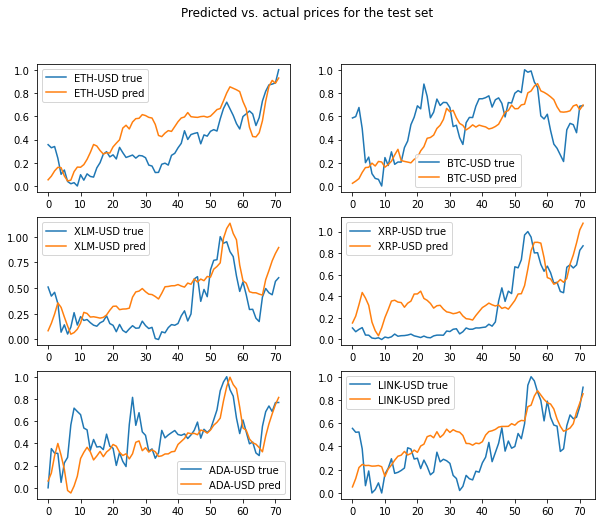

In [95]:
plot(y_test_scaled, y_pred_test, 'Predicted vs. actual prices for the test set')